###Imports

In [36]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import sentiment
#from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###Data Analysis

In [ ]:
TMR_PATH = '/content/IMDb_TSR_Reviews.csv' 

df = pd.read_csv(TMR_PATH, usecols = ['Reviews','Scores'])
df. rename(columns = {'Reviews':'review', 'Scores':'rating'}, inplace = True)
df.head()

,review,rating
0,Why do I want to write the 234th comment on Th...,10.0
1,The Shawshank Redemption is written and direct...,10.0
2,"In its Oscar year, Shawshank Redemption (writt...",10.0
3,This movie is not your ordinary Hollywood flic...,10.0
4,I'm trying to save you money; this is the last...,10.0


In [ ]:
print("Shape", df.shape)

Shape (10086, 2)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10086 entries, 0 to 10085
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  10086 non-null  object 
 1   rating  9522 non-null   float64
dtypes: float64(1), object(1)
memory usage: 157.7+ KB


In [ ]:
df.isna().sum()
#there are 564 reviews which do not has associated ratings.

review      0
rating    564
dtype: int64

In [ ]:
df = df[df['rating'].notna()]
print("Shape after filtering out NA ratings",df.shape)

Shape after filtering out NA ratings (9522, 2)


In [ ]:
df['rating'] = df['rating'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9522 entries, 0 to 10085
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9522 non-null   object
 1   rating  9522 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 223.2+ KB


In [ ]:
ratings = df.rating.unique()
print("Rating values : ",np.sort(ratings))
print("Len ( Rating ) : ",len(ratings))

Rating values :  [ 1  2  3  4  5  6  7  8  9 10]
Len ( Rating ) :  10


In [ ]:
print(df["rating"].value_counts())

10    6574
9     1601
8      579
7      251
6      147
1      146
5      110
4       54
3       35
2       25
Name: rating, dtype: int64


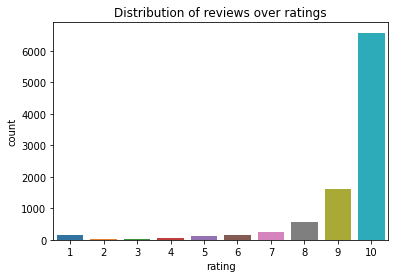

In [ ]:
sns.countplot(df['rating'], data=df)
plt.title("Distribution of reviews over ratings")
plt.show()

* Every movie has a rating between 1-10.
* We have classified the ratings into 3 categories - Positive, Neutral, Negative.
* Positive = Rating [7,10]
* Neutral = Rating [5,6]
* Negative = Rating [1,4]
* We are focusing on Binary Classification of sentiments - Positive and Negative. Thus, we further filter out neutral rated reviews.


In [ ]:
def generate_label(score):
    if score > 6 :
      return 'positive' #1
    elif score > 4 :
      return 'neutral' #0
    else : 
      return 'negative' #-1
    
#Assigning label to the dataset
df['label'] = df.apply(lambda x: generate_label(x['rating']), axis=1)
df.head(5)

,review,rating,label
0,Why do I want to write the 234th comment on Th...,10,positive
1,The Shawshank Redemption is written and direct...,10,positive
2,"In its Oscar year, Shawshank Redemption (writt...",10,positive
3,This movie is not your ordinary Hollywood flic...,10,positive
4,I'm trying to save you money; this is the last...,10,positive


In [ ]:
print(df["label"].value_counts())

positive    9005
negative     260
neutral      257
Name: label, dtype: int64


In [ ]:
#filter out neutral sentiments
df= df[df['label']!= 'neutral']

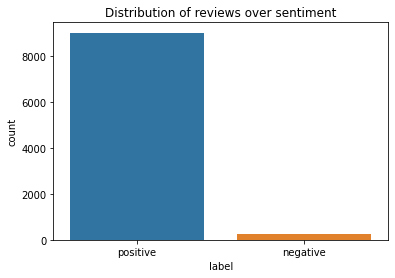

In [ ]:
sns.countplot(df['label'], data=df)
plt.title("Distribution of reviews over sentiment")
plt.show()

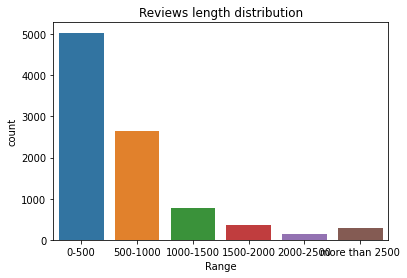

In [ ]:
def calc_len(x):
  #print(len(x))
  return len(x)

df['wordcount'] = df['review'].apply(calc_len)
#df.head(5)

bins = [-1, 500, 1000, 1500, 2000, 2500, np.inf]
labels=['0-500','500-1000','1000-1500', '1500-2000', '2000-2500', 'more than 2500']
df['bins'] = pd.cut(df['wordcount'], bins=bins, labels=labels)

sns.countplot(df['bins'], data=df)
plt.title("Reviews length distribution")
plt.xlabel("Range")
plt.show()

In [ ]:
df_wc=df.groupby(['bins','label']).size()
print (df_wc)

bins            label   
0-500           negative     155
                positive    4881
500-1000        negative      55
                positive    2602
1000-1500       negative      21
                positive     744
1500-2000       negative      16
                positive     349
2000-2500       negative       8
                positive     138
more than 2500  negative       5
                positive     291
dtype: int64


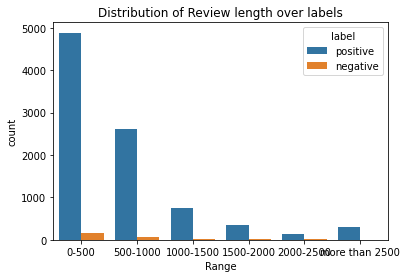

In [ ]:
sns.countplot(x='bins', hue='label', data=df)
plt.title("Distribution of Review length over labels")
plt.xlabel("Range")
plt.show()

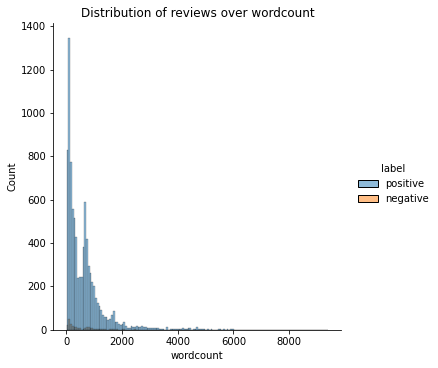

In [ ]:
sns.displot(x= 'wordcount', hue = 'label', data = df)
plt.title('Distribution of reviews over wordcount')
plt.show()

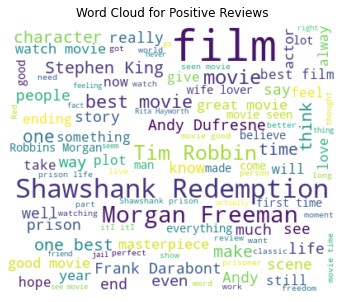

In [87]:
wcp = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df[df.label == 'positive'].review))

plt.figure(figsize=(15,5))
plt.imshow(wcp, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews")
plt.show()

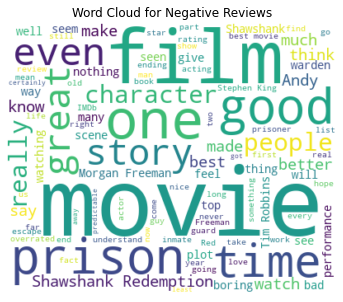

In [88]:
wcn = WordCloud(width=400, height=330, max_words=100, background_color='white').generate(" ".join(df[df.label == 'negative'].review))

plt.figure(figsize=(15,5))
plt.imshow(wcn, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews")
plt.show()

In [102]:
pos_wf = list(wcp.words_.keys())
neg_wf = list(wcn.words_.keys())
print("Positive Reviews : ",pos_wf)
print("Negative Reviews : ",neg_wf)
common = [x for x in pos_wf if x in neg_wf]
print("Common : ", common)

Positive Reviews :  ['film', 'Shawshank Redemption', 'Morgan Freeman', 'Tim Robbin', 'movie', 'best movie', 'one', 'character', 'think', 'make', 'time', 'one best', 'Stephen King', 'way', 'even', 'Andy', 'life', 'story', 'Andy Dufresne', 'people', 'really', 'say', 'know', 'Frank Darabont', 'well', 'end', 'much', 'scene', 'see', 'prison', 'good movie', 'watch movie', 'actor', 'masterpiece', 'great movie', 'year', 'still', 'ending', 'something', 'plot', 'give', 'love', 'hope', 'now', 'take', 'best film', 'feel', 'alway', 'will', 'Robbins Morgan', 'come', 'made', 'believe', 'man', 'wife lover', 'movie seen', 'everything', 'first time', 'lot', 'good', 'Shawshank prison', 'world', 'live', 'better', 'movie time', 'perfect', 'itI itI', 'prisoner', 'movie good', 'got', 'want', 'moment', 'thought', 'Red', 'watch', 'seen movie', 'need', 'part', 'word', 'prison life', 'long', 'person', 'classic', 'watching', 'show', 'freedom', 'review', 'work', 'Rita Hayworth', 'actually', 'seem', 'feeling', 'fac

* Words like Movie, Film, Shawshank, Redemption, Morgan, Freeman, Stephen King are frequent in both the sentiments, thus they do not help in classification. 
* We will ignore these words during data cleaning.

### Data Cleaning

In [103]:
IGNORE_WORDS = ['morgan', 'freeman', 'shawshank', 'redemption', 'movie', 'film', 'stephen', 'king', 'time', 'character','one', 'andy', 'make', 'way', 'actor', 'plot','end']

def clean_data(review):
    #print("Org : " , review)

    #HTML tag
    raw_text=BeautifulSoup(review, 'html').get_text()
    #print("Html : ",raw_text)

    #urls
    raw_text = re.sub(r"(www|http:|https:)+[\S]+[\w]", "", raw_text)
    #print("Links : ",raw_text)
    
    #non English character
    letters = re.sub('[^a-zA-Z]', ' ', raw_text)
    #print("Non English : ",letters)

    #lowercase
    tokens = letters.lower().split() 

    #filter ignore_words
    #tokens = [token for token in tokens if token not in IGNORE_WORDS] 
    #print(tokens)

    #stopwords and stemming
    stopwords = nltk.corpus.stopwords.words('english')
    wn = nltk.WordNetLemmatizer()
    words = [wn.lemmatize(w) for w in tokens if w not in stopwords ]
    
    #ignore_words
    IGNORE_WORDS_LEM = [wn.lemmatize(w).lower() for w in IGNORE_WORDS]
    words = [w for w in words if w not in IGNORE_WORDS_LEM]

    #ps = nltk.PorterStemmer()
    #words = [ps.stem(w) for w in tokens if w not in stopwords]
    
    #print("Tokens : ",words)
    return words

In [104]:
clean_data("film! this is test aaa <br> https://urls.com, is good with <b>technology</b>! Tests failed? Shawshank movies one two")

['test', 'aaa', 'good', 'technology', 'test', 'failed', 'two']

In [105]:
df_X =  df['review'].apply(clean_data)
df_Y = df['label']
print(df_X.shape, df_Y.shape)

(9265,) (9265,)


In [106]:
def generate_vocab(data): 
  vocab = set()
  for clean_x in data : #cleaned_data
    for word in clean_x :
      #print(word)
      vocab.add(word)
      #break
  return sorted(vocab)

vocab = generate_vocab(df_X)
print("Vocab : ",vocab)
print("Length : ", len(vocab))

Vocab :  ['aa', 'aaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaadaftzgzhxhxjxjxjxjxjxjxjxjxhxjxhxhdjdhxhxhdhxjxjxjdjxjdhxjdhxhxnzgsjtdtnsntsgndgnzgxhdhxhcjcjfufydydykdydydydyjsykdyksykdykdyldydudlydykdyksydkydysykdykdyykdkydykdykdydydkydykdyk', 'aaahhh', 'ab', 'aback', 'abacus', 'abandon', 'abandoned', 'abandonment', 'abated', 'abbreviation', 'abcdsjsjjsjsnmslsldmmskskskjzjsjjsjsnnsksknxojxksbjsjjdjdjdjhdjdjdjjsjjjsjsksksmsmsksn', 'abd', 'abdy', 'abetted', 'abhijeet', 'abhor', 'abide', 'abiding', 'ability', 'abit', 'abject', 'abjectly', 'able', 'ably', 'abnormally', 'abolish', 'abot', 'abotu', 'abound', 'abroad', 'abrupt', 'abruptly', 'abscondment', 'absence', 'absent', 'absoloutely', 'absolut', 'ab

###Feature Extraction

####BagOfWords

In [107]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(analyzer = "word", tokenizer = lambda x: x, lowercase=False,  preprocessor = None, stop_words = None)
train_features = bow_vectorizer.fit_transform(df_X).toarray()
dfbow = pd.DataFrame(data=train_features,columns = bow_vectorizer.get_feature_names())
print(dfbow.shape)
dfbow.head()

(9265, 18415)


,aa,aaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaadaftzgzhxhxjxjxjxjxjxjxjxjxhxjxhxhdjdhxhxhdhxjxjxjdjxjdhxjdhxhxnzgsjtdtnsntsgndgnzgxhdhxhcjcjfufydydykdydydydyjsykdyksykdykdyldydudlydykdyksydkydysykdykdyykdkydykdykdydydkydykdyk,aaahhh,ab,aback,abacus,abandon,...,zjk,zkeveoz,zma,zni,zombie,zone,zoolander,zoom,zooming,zu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
features_count =  np.sum(train_features,axis=0)
features_count = pd.DataFrame(dict(features = bow_vectorizer.get_feature_names(), counts = features_count))
features_count.sort_values('counts', ascending=False)[0:20]

,features,counts
12427,prison,5600
1516,best,4974
15511,story,4745
9454,life,4208
9486,like,3916
7027,good,3734
17829,watch,3581
7842,hope,3521
7168,great,3476
5638,ever,3317


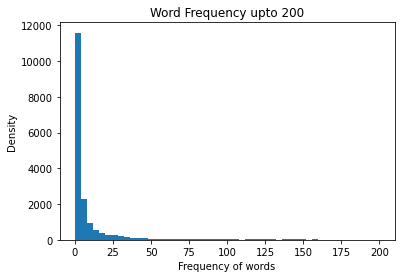

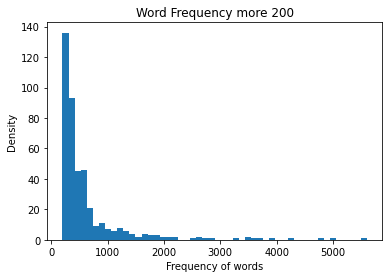

In [126]:
plt.title("Word Frequency upto 200")
plt.hist(features_count.counts, bins=50, range=(0,200))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

plt.title("Word Frequency more 200")
plt.hist(features_count.counts, bins=50, range=(200,5600))
plt.xlabel("Frequency of words")
plt.ylabel("Density")
plt.show()

In [129]:
print("Features in bag of words : ",len(bow_vectorizer.vocabulary_))

Features in bag of words :  18415


####  TF-IDF

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, use_idf=True) #stop_words='english' , smooth_idf=True(default)
tfidf = tfidf_vectorizer.fit_transform(df_X)

#print("Vocab : \n ",tfidf_vectorizer.vocabulary_) #mapping{word: feature index}
print("IDF Vector : \n ",tfidf_vectorizer.idf_)

IDF Vector : 
  [9.44095989 9.44095989 9.44095989 ... 8.52466915 9.03549478 9.44095989]


In [131]:
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(20)

,idf_weights
best,2.065391
story,2.130744
watch,2.287126
prison,2.324972
ever,2.326597
life,2.336816
great,2.382632
like,2.425247
good,2.455781
seen,2.488709


These are only IDF values. Inverse Document Frequency Score is inversely proportional to the usage frequency of the words. Not so important words which may not tell the context has lower IDF since they appear in every sentences.

In [132]:
idx = 5
print("\n Review tokens : ",df_X.loc[idx])
df_tfidf = pd.DataFrame(tfidf[idx].T.todense(), index=tfidf_vectorizer.get_feature_names_out (), columns=["tfidf"])
df_tfidf.sort_values(by=["tfidf"],ascending=False).head(20)


 Review tokens :  ['finest', 'made', 'recent', 'year', 'poignant', 'story', 'hope', 'hope', 'get', 'like', 'tell', 'lesson', 'life', 'people', 'talk', 'even', 'year', 'also', 'story', 'freedom', 'freedom', 'isolation', 'rule', 'bigotry', 'hate', 'robbins', 'majestic', 'performance', 'learns', 'relationship', 'strong', 'feel', 'first', 'moment', 'contact', 'another', 'also', 'wonderful', 'performance', 'legend', 'james', 'whitmore', 'brook', 'shine', 'go', 'back', 'world', 'find', 'world', 'grew', 'fast', 'never', 'even', 'got', 'chance', 'blink', 'story', 'brought', 'screen', 'great', 'elegance', 'excitement', 'extraordinary', 'motion', 'people', 'talking', 'year']


,tfidf
year,0.225923
freedom,0.201783
elegance,0.183971
world,0.181211
bigotry,0.173864
blink,0.168581
contact,0.167250
grew,0.165984
story,0.165875
isolation,0.164194


Here, we see TFIDF values for 5th document of our trainset. We can explore other values by updating the value of idx.

In [134]:
print("Number of features : ",len(tfidf_vectorizer.vocabulary_))

Number of features :  18415
